# wPLI

In [2]:
# imports
from pathlib import Path
import re

import numpy as np
import pandas as pd
from scipy.io import loadmat

import mne
from mne_connectivity import spectral_connectivity_time


# MATLAB
## Prepare raw data for MATLAB

In [ ]:
target_ch = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6',
             'P1', 'P2', 'P3', 'P4', 'P5', 'P6']

for file_dir in sorted(Path('data/clean_data/').glob('*.fif')):
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo', file_dir.stem).groups()
    
    # open data
    epochs = mne.read_epochs(file_dir, verbose=0)
    epochs.pick_channels(target_ch)
    
    # epoch to continuous
    ch_names = epochs.ch_names
    data = np.hstack(epochs.get_data())
    info = mne.create_info(ch_names,
                       1000,
                       len(ch_names)*['eeg'],
                       )
    raw = mne.io.RawArray(data, info)
    raw.save(f'data/Data4MATLAB_PLI/{subject}_{task}_raw.fif')

## Open mat file and create datatable for wPLI connectivities

In [21]:
all_wpli = loadmat('all_wpli.mat')

# create a list of files
trial_list = []
for file_dir in sorted(Path('data/clean_data/').glob('*.fif')):
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo', file_dir.stem).groups()
    trial_list.append(subject + '_' + task)

wpli_agg = {}
for i in range(len(trial_list)):
    wpli_agg[trial_list[i]] = all_wpli['all_conns'][0][0][i].mean(1)
    
# connectivity labels
conn_info = all_wpli['all_conns'][0][0][-1][0][0][0]

conn_labels = []
for i in range(len(conn_info)):
    conn_labels.append(conn_info[i][0][0] + '_' + conn_info[i][1][0])

conn_df = pd.DataFrame.from_dict(wpli_agg, columns=conn_labels, orient='index')

numpy.ndarray

In [234]:
# create labels for frontoparietal connections
inter_conn = [i
             for i in conn_labels
             if i[0] + i[3] == 'PP' or i[0] + i[3] == 'FF']
ind = [np.where(np.array(conn_labels) == i)[0][0] for i in inter_conn]
frontal_parietal = np.delete(conn_labels, ind)

frontal_parietal = {
'left-frontal_left-pariental' : ['P3_F3', 'P1_F3', 'P5_F3', 'F1_P3', 'F5_P3', 'P1_F1', 'P5_F1', 'P1_F5', 'P5_F5'],
'left-frontal_right-pariental': ['P4_F3', 'P6_F3', 'P2_F3', 'F1_P4', 'F5_P4', 'P2_F1', 'P6_F1', 'P2_F5', 'P6_F5'],
'right-frontal_left-pariental' : ['P3_F4', 'P5_F4', 'F2_P3', 'P1_F2', 'P5_F2', 'P1_F6', 'P5_F6', 'P1_F4', 'F6_P3'],
'right-frontal_right-pariental' : ['P4_F4', 'P2_F4', 'P6_F4', 'F2_P4', 'F6_P4', 'P2_F2', 'P6_F2', 'P2_F6', 'P6_F6']
}

# aggregate connections between frontal and parietal areas
fp_df = pd.DataFrame()
for k,v in frontal_parietal.items():
    fp_df[k] = conn_df[v].mean(1)

# create labels for connections between traget channels
target_ch = ['P4', 'P3', 'F4', 'F3']
target_connections = pd.DataFrame(columns=target_ch, index=target_ch)
target_connections = target_connections.apply(lambda x: x.index + '_' + x.name)
target_connections = target_connections.values[np.triu_indices(target_connections.shape[0], k=1)]

# join aggregated connectivities and target channel connectivities
df = fp_df.join(conn_df[target_connections])

In [ ]:
# Merge with behavioral data
# open behavioral data and ids map
bh = pd.read_csv('data/behavioral_data/archived/plb_hyp_data.csv', index_col='index')
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.drop_duplicates('bids_id')
ids_map = ids_map[['bids_id']]
ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
bh = bh.join(ids_map, how='right')
bh = bh.melt(
    id_vars=['procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
             'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4'],
    value_vars=['hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4'])
bh['session'] = bh['variable'].apply(lambda x:x.split('_')[2])
bh['procedure'] = bh.apply(lambda r: r['procedure_type_'+r['session']], axis=1)
bh['description'] = bh.apply(lambda r: r['description_type_'+r['session']], axis=1)
bh = bh[['bids_id', 'value', 'procedure', 'description', 'session']].sort_values(by=['bids_id', 'session']).set_index('bids_id')
bh = bh.rename(columns={'value':'hypnosis_depth'})
bh.reset_index(inplace=True)

df[['bids_id', 'condition']] = df.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
df['session'] = df['condition'].apply(lambda x:x[-1])
df.reset_index(drop=True, inplace=True)
df['bids_id'] = df['bids_id'].apply(lambda x:x[4:])
df = pd.merge(bh, df, how='right', on=['session', 'bids_id'], right_index=False)
df = df.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
df.insert(1, 'condition', df.pop('condition'))
df.head()

# correct for procedure, description, and hypnosis depth of baseline rows
df.loc[df['condition'] == 'baseline1', ['procedure', 'description']] = 'baseline'
df.loc[df['condition'] == 'baseline2', ['procedure', 'description']] = 'baseline'
df.loc[df['condition'] == 'baseline1', ['hypnosis_depth']] = None
df.loc[df['condition'] == 'baseline2', ['hypnosis_depth']] = None

# save
# df.to_csv('wpli_alpha2.csv', index=0)

# Python
## wPLI at sensor level

In [32]:
# constants
freqs = np.arange(1, 42, 1)
foi = np.array([
        [1, 4],
        [4, 8],
        [8, 13],
        [13, 30],
        [30, 42]
        ])
fmin = tuple(foi[:, 0])
fmax = tuple(foi[:, 1])

## open a sample eeg data and create connectivity labels based on its channel names
epochs = mne.read_epochs('data/clean_data/sub-01_ses-01_task-experience1_proc-clean_epo.fif',
                         verbose=0)
epochs.drop_channels(['M1', 'M2'])
epochs.pick_types(eeg=True)
ch_names = epochs.ch_names

conn_labels = pd.DataFrame(columns=ch_names, index=ch_names)
conn_labels = conn_labels.apply(lambda x: x.index + '\N{left right arrow}' + x.name)
conn_labels = conn_labels.values[np.tril_indices(conn_labels.shape[0], k=-1)]

## bands
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# define a function that get a numpy array and return a dataframe of FCs
def calculate_wpli(data, freqs, fmin, fmax, bands, subject, task, conn_labels, sfreq,
                   verbose=0, decim=20):
  conn = spectral_connectivity_time(data,
                                    freqs=freqs,
                                    method='wpli',
                                    fmin=fmin,
                                    fmax=fmax,
                                    sfreq=sfreq,
                                    faverage=True,
                                    average=True,
                                    verbose=verbose,
                                    decim=decim,
                                    n_cycles=5
                                  )

  # get data
  conn = conn.get_data(output='dense')
  
  # create a dataframe from a dictionary of connectivities in different bands
  temp = {}
  for i, b in enumerate(bands):
      temp[b] = conn[:, :, i][np.tril_indices(conn.shape[0], k=-1)]

  df = pd.DataFrame(temp, index=conn_labels).stack().reset_index()
  df['conn'] = df['level_0'] + '_' + df['level_1']
  
  return df.drop(columns=['level_0', 'level_1']).set_index('conn').T.set_index([pd.Index([subject + '_' + task])])

In [ ]:
df_total = pd.DataFrame([]) # connectivity collectors

for subject_path in sorted(Path('data/clean_data').glob('*.fif')):
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo.*', subject_path.stem).groups()
    
    if 'experience' in task:
        # open data and modify
        print(f'>>>>>>>>>>>>>> Processing {subject} -- {task}')
        epochs = mne.read_epochs(subject_path, verbose=0)
        epochs.drop_channels(['M1', 'M2'])
        epochs.pick_types(eeg=True)
        
        # set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        epochs.set_montage(montage)
        print(epochs.info)
        
        # surface laplacian
        epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
        data = np.array(np.split(np.hstack(epochs_csd.get_data()), 10, axis=1))
        
        df = calculate_wpli(data, freqs, fmin, fmax, bands, subject, task, conn_labels, sfreq=1000)
        
        df_total = pd.concat([df_total, df])
        del df

In [9]:
# behavioral data
bh = pd.read_csv('data/behavioral_data/behavioral_data.csv')[:208]
bh['bids_id'] = bh['bids_id'].astype('int64')
bh['session'] = bh['session'].astype('int64')

# append connectivity and behavioral data 
df_total[['bids_id', 'condition']] = df_total.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
df_total['session'] = df_total['condition'].apply(lambda x:int(x[-1]))
df_total['bids_id'] = df_total['bids_id'].apply(lambda x:int(x[4:]))

df_total.reset_index(drop=True, inplace=True)
df_total = pd.merge(bh, df_total, how='right', on=['session', 'bids_id'], right_index=False)
df_total = df_total.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
df_total.insert(1, 'condition', df_total.pop('condition'))
# df_total.to_csv('data/classification_datasets/wpli_sensor.csv')

## wPLI at source level

In [49]:
# create connectivity labels
# labels
yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemisferes = ['lh', 'rh']

# labels based on Yeo2011 atlas orders
networks = [yeo7[k]+'_'+ hemisferes[i] for k in yeo7.keys() for i in range(len(hemisferes))]

conn_labels = pd.DataFrame(index=networks, columns=networks)
conn_labels = conn_labels.apply(lambda x: x.index + '\N{left right arrow}' + x.name)
conn_labels = conn_labels.values[np.tril_indices(conn_labels.shape[0], k=-1)]

In [ ]:
df_total = pd.DataFrame([]) # connectivity collectors
for subject_path in sorted(Path('data/parcellated_source_yeo7').glob('*.npz')):
    subject, task = re.search('(.*)_task-(.*)_labels.*', subject_path.stem).groups()
    
    if 'experience' in task:
        
        label_ts = np.load(subject_path)['labels']
        data = np.hstack(label_ts)
        
        # To get 30-seconds time segments, we need to split source arrays into 10 segments.
        # To make the array divisible by 10, we cut off a few data points (less than 10) at the end:
        idx = data.shape[1] - data.shape[1]%10
        data = data[:, :idx]
        data = np.array(np.split(data, 10, axis=1))
        
        print(f'>>>>>>>>>>>>> Processing {subject} --- {task}')
        # calculate wpli
        df = calculate_wpli(data, freqs, fmin, fmax, bands, subject=subject, task=task, conn_labels=conn_labels,
                            verbose=0, decim=10, sfreq=512)
        
        # append wpli
        df_total = pd.concat([df_total, df])
        del df

In [51]:
# prepare data for classification
# behavioral data
bh = pd.read_csv('data/behavioral_data/behavioral_data.csv')[:208]
bh['bids_id'] = bh['bids_id'].astype('int64')
bh['session'] = bh['session'].astype('int64')

# append connectivity and behavioral data 
df_total[['bids_id', 'condition']] = df_total.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
df_total['session'] = df_total['condition'].apply(lambda x:int(x[-1]))
df_total['bids_id'] = df_total['bids_id'].apply(lambda x:int(x[4:]))

df_total.reset_index(drop=True, inplace=True)
df_total = pd.merge(bh, df_total, how='right', on=['session', 'bids_id'], right_index=False)
df_total = df_total.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
df_total.insert(1, 'condition', df_total.pop('condition'))
df_total.head()
# df_total.to_csv('data/classification_datasets/wpli_source.csv')

,bids_id,condition,hypnosis_depth,procedure,description,session,Visual_rh↔Visual_lh_theta,Somatomotor_lh↔Visual_lh_theta,Somatomotor_lh↔Visual_rh_theta,Somatomotor_rh↔Visual_lh_theta,...,Medial_Wall_rh↔DorsalAttention_rh_theta,Medial_Wall_rh↔VentralAttention_lh_theta,Medial_Wall_rh↔VentralAttention_rh_theta,Medial_Wall_rh↔Limbic_lh_theta,Medial_Wall_rh↔Limbic_rh_theta,Medial_Wall_rh↔Frontoparietal_lh_theta,Medial_Wall_rh↔Frontoparietal_rh_theta,Medial_Wall_rh↔Default_lh_theta,Medial_Wall_rh↔Default_rh_theta,Medial_Wall_rh↔Medial_Wall_lh_theta
0,1,experience1,6.0,whitenoise,hypnosis,1,0.228656,0.232527,0.229254,0.250586,...,0.217584,0.225066,0.216548,0.243622,0.230249,0.228598,0.207803,0.217937,0.212577,0.217209
1,1,experience2,7.0,relaxation,control,2,0.196593,0.201141,0.198193,0.202087,...,0.261826,0.214153,0.258664,0.237530,0.213918,0.207511,0.265022,0.226803,0.231416,0.210376
2,1,experience3,8.0,confusion,hypnosis,3,0.244968,0.227123,0.234869,0.217056,...,0.223537,0.230297,0.196795,0.188696,0.229231,0.232566,0.208990,0.220320,0.214723,0.198031
3,1,experience4,1.0,embedded,control,4,0.213406,0.212765,0.218032,0.218951,...,0.226774,0.206081,0.216773,0.235497,0.210681,0.224790,0.213226,0.215299,0.232151,0.233220
4,2,experience1,1.0,relaxation,control,1,0.288484,0.270219,0.262734,0.265245,...,0.269966,0.279958,0.258372,0.297298,0.280673,0.273844,0.271155,0.289801,0.260367,0.275900


In [ ]:
y_preds = []
grid_results = pd.DataFrame()

# Choose cross-validation techniques for the inner and outer loops
outer_cv = GroupShuffleSplit(n_splits=30, test_size=0.3)
inner_cv = GroupShuffleSplit(n_splits=5, test_size=0.2)

# PIPELINE
pipe = Pipeline(steps=[
('extract', FeatureExtractor()),
('zerovar', VarianceThreshold(threshold=0.0)),
('scale', StandardScaler()),
# ('select', SelectFromModel(estimator=SVC(max_iter=1000000, kernel="linear"), threshold='median')),
('clf', SVC(max_iter=1000000, kernel='linear')),
])

# grid search
grid_params = [{
    'extract__kind': ['correlation sensor'],
    'extract__frequency_band': ['theta'],
    # 'select' : [SelectFromModel(estimator=SVC(max_iter=1000000, kernel="linear"), threshold='median'), 'passthrough'],
}]

test_accuraies = []
for train, test in outer_cv.split(X, y, groups):

    # Nested CV with parameter optimization
    grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
    grid.fit(X[train], y[train], groups=groups.iloc[train])
    grid_result = pd.DataFrame(grid.cv_results_)
    grid_results = pd.concat([grid_results, grid_result], axis=0)
    
    # accrucy on the test set using the best estimator
    y_pred = grid.predict(X[test])
    y_preds.append(y_pred)
    test_accuraies.append((y[test] == y_pred).mean())

## Investigating ...

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

for subject_path in sorted(Path('data/clean_data').glob('*.fif'))[:3]:
    if 'experience' in task:
        # open data and modify
        print(f'>>>>>>>>>>>>>> Processing {subject} -- {task}')
        epochs = mne.read_epochs(subject_path, verbose=0)
        epochs.drop_channels(['M1', 'M2'])
        epochs.pick_types(eeg=True)
        
        # set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        epochs.set_montage(montage)
        print(epochs.info)
            
        # surface laplacian
        epochs_csd = mne.preprocessing.compute_current_source_density(epochs)

        data = np.array(np.split(np.hstack(epochs_csd.get_data()), 10, axis=1))
        # data = np.array([np.hstack(epoch_csd.get_data())])
        
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo.*', subject_path.stem).groups()
    conn = spectral_connectivity_time(data,
                                        freqs=freqs,
                                        method='wpli',
                                        fmin=fmin,
                                        fmax=fmax,
                                        sfreq=1000,
                                        faverage=True,
                                        average=True,
                                        verbose=0,
                                        decim=20,
                                        n_cycles=5
                                    )

    # get data
    conn2 = conn.get_data(output='dense')

    # create a dataframe from a dictionary of connectivities in different bands
    temp = {}
    for i, b in enumerate(bands):
        temp[b] = conn2[:, :, i][np.tril_indices(conn2.shape[0], k=-1)]

    df = pd.DataFrame(temp, index=conn_labels).stack().reset_index()
    df['conn'] = df['level_0'] + '_' + df['level_1']

    df = df.drop(columns=['level_0', 'level_1']).set_index('conn').T.set_index([pd.Index([subject + '_' + task])])

>>>>>>>>>>>>>> Processing sub-01 -- experience1
<Info | 15 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 57 EEG
 custom_ref_applied: True
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 60 items (3 Cardinal, 57 EEG)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 line_freq: 50.0
 lowpass: 42.0 Hz
 meas_date: 2021-03-11 12:14:23 UTC
 meas_id: 4 items (dict)
 nchan: 57
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>
Fitted sphere radius:         94.7 mm
Origin head coordinates:      -0.8 14.3 45.7 mm
Origin device coordinates:    -0.8 14.3 45.7 mm


### how two wplis are different? (using heatmap/imshow)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

wpli_seg = pd.read_csv('data/classification_datasets/wpli_source.csv', index_col=0)
wpli_noseg = pd.read_csv('data/classification_datasets/others/wpli_source_without_segmentation.csv', index_col=0)

conn_cols = [i for i in wpli_seg.columns if wpli_seg[i].dtype == 'float64' and 'gamma' in i]

In [ ]:
new_cols = [i.split('\N{left right arrow}') for i in conn_cols]
level2 = [i[1].replace('_gamma', '') for i in new_cols]
level1 = list(np.array(new_cols)[:, 0])
new_idx = pd.MultiIndex(levels=[level1, level2])

In [ ]:
df = wpli_noseg[conn_cols].T
df.set_index(new_cols)

### How smaller time window affects wPLI?
first let's compute wPLI for 10 seconds window only for theta band (this is the dataset that had the lowest classification accuracy). For doing so, first run the above cells where the the function that calculates wPLI is defined (Pick only theta as the frequency of interest to increase the computation speed). Then run the following cell to compute wPLI for 10 seconds window.

In [ ]:
df_total = pd.DataFrame([]) # connectivity collectors
for subject_path in sorted(Path('data/parcellated_source_yeo7').glob('*.npz')):
    subject, task = re.search('(.*)_task-(.*)_labels.*', subject_path.stem).groups()
    
    if 'experience' in task:
        
        label_ts = np.load(subject_path)['labels']
        data = np.hstack(label_ts)
        
        # To get 30-seconds time segments, we need to split source arrays into 10 segments.
        # To make the array divisible by 10, we cut off a few data points (less than 10) at the end:
        idx = data.shape[1] - data.shape[1]%30
        data = data[:, :idx]
        data = np.array(np.split(data, 30, axis=1))
        
        print(f'>>>>>>>>>>>>> Processing {subject} --- {task}')
        # calculate wpli
        df = calculate_wpli(data, freqs, fmin, fmax, bands, subject=subject, task=task, conn_labels=conn_labels,
                            verbose=0, decim=10, sfreq=512)
        
        # append wpli
        df_total = pd.concat([df_total, df])
        del df

# prepare data for classification
# behavioral data
bh = pd.read_csv('data/behavioral_data/behavioral_data.csv')[:208]
bh['bids_id'] = bh['bids_id'].astype('int64')
bh['session'] = bh['session'].astype('int64')

# append connectivity and behavioral data 
df_total[['bids_id', 'condition']] = df_total.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
df_total['session'] = df_total['condition'].apply(lambda x:int(x[-1]))
df_total['bids_id'] = df_total['bids_id'].apply(lambda x:int(x[4:]))

df_total.reset_index(drop=True, inplace=True)
df_total = pd.merge(bh, df_total, how='right', on=['session', 'bids_id'], right_index=False)
df_total = df_total.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
df_total.insert(1, 'condition', df_total.pop('condition'))
df_total.head()
# df_total.to_csv('data/classification_datasets/wpli_source.csv')

Now we want to plot the wPLI for 10 seconds window and compare it with the wPLI for 30 seconds window. For doing so, run the following cell.

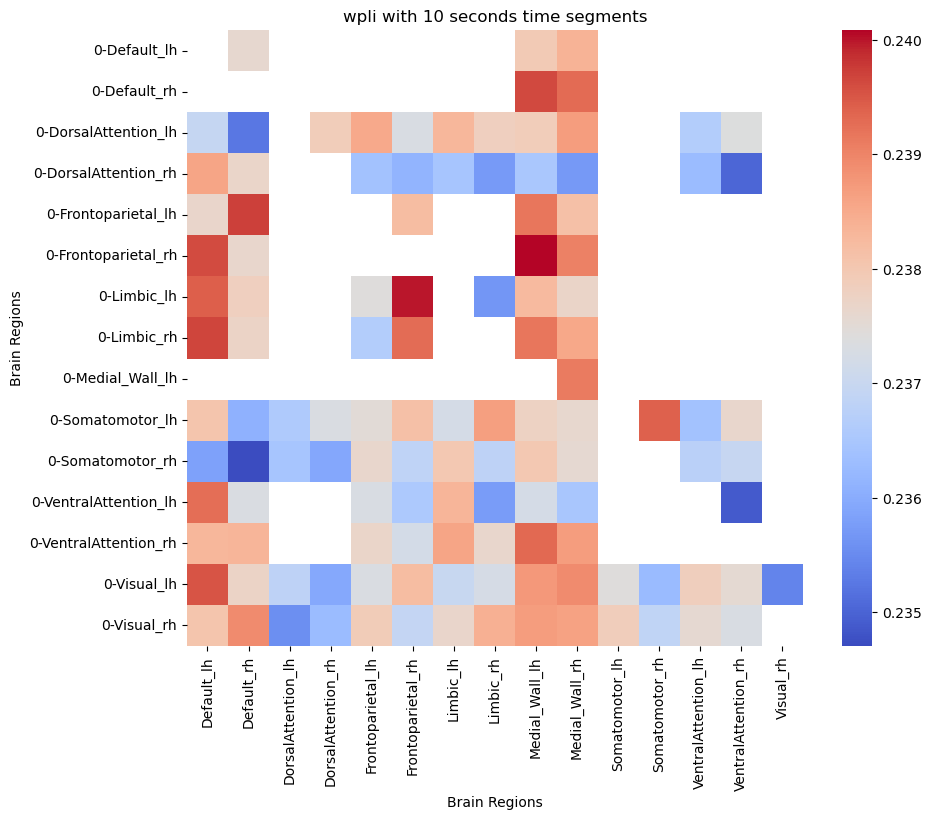

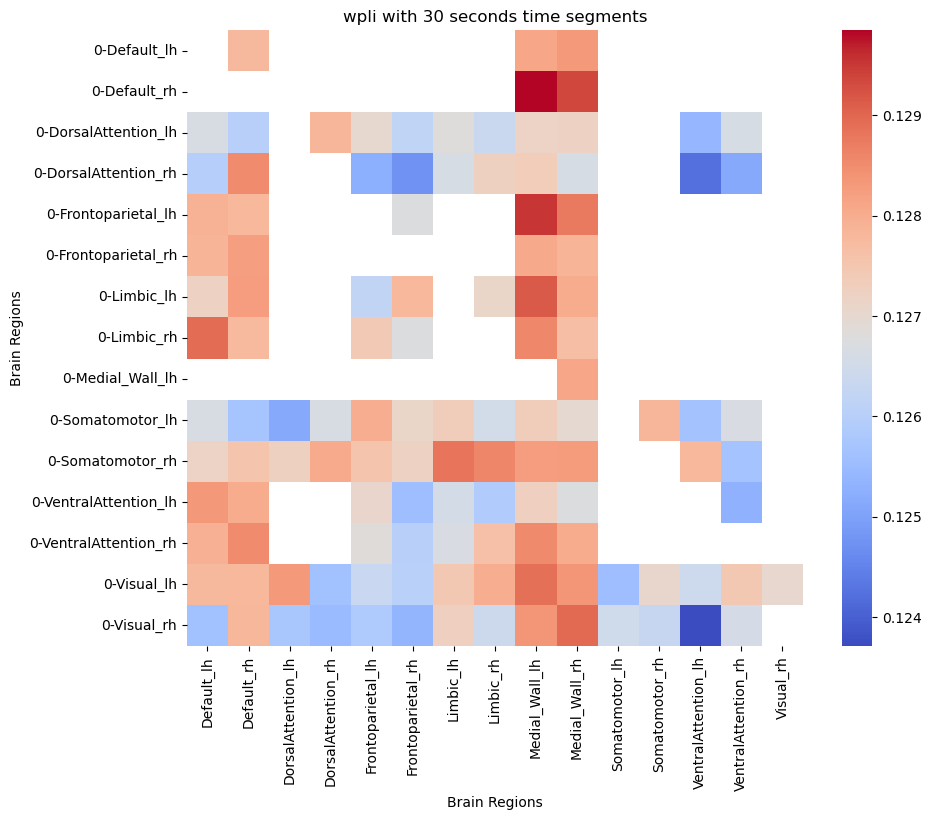

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_df(df, band=None):
    if band != None:
        cols = [c for c in df.columns if band in c]
        df = df[cols]
    
    # remove band name from column names
    idx = len(band) + 1
    new_cols = [c[:-idx] for c in df.columns]
    df.columns = new_cols
    
    # average over subjects (rows)
    df = df.mean(axis=0).to_frame().T

    # # Split column names by special character and create multi-level column index
    new_cols = []
    for c in df.columns:
        new_cols.append(tuple(c.split('\N{left right arrow}')))
    df.columns = pd.MultiIndex.from_tuples(new_cols)

    # Bring the second columns in a multicolumn dataframe into the index
    df = df.stack(level=1)
    return df

def plot_connectivity_matrix(df, title, figsize=(10, 8)):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the heatmap
    sns.heatmap(df, cmap='coolwarm', square=True, ax=ax)

    # Set the title and axis labels
    ax.set_title(title)
    ax.set_xlabel('Brain Regions')
    ax.set_ylabel('Brain Regions')

    # Show the plot
    plt.show()
    

# ----------------- wpli with 10 seconds time segments -----------------
wpli_10s = df_total.copy()
# new_cols = [c[:-6] for c in wpli_10s.columns]
# wpli_10s.columns = new_cols
wplis_10s = prepare_df(wpli_10s, band='theta')
plot_connectivity_matrix(wplis_10s, title='wpli with 10 seconds time segments')

# ----------------- wpli with 30 seconds time segments -----------------
# Load the data
wplis_30s = pd.read_csv('data/classification_datasets/wpli_source.csv')
wplis_30s = prepare_df(wplis_30s, band='theta')
plot_connectivity_matrix(wplis_30s, title='wpli with 30 seconds time segments') 